In [1]:
from load_covid_data import load_covid_data
import numpy as np
from sklearn.neural_network import MLPClassifier, MLPRegressor
from accuracy_score import accuracy_score
from sklearn.model_selection import train_test_split
from GridSearch import *
import pandas as pd
from mean_square_error import MSE
from sklearn.utils import shuffle


In [2]:

# Loading covid dataset
headers, X, Y = load_covid_data()
X, Y = shuffle(X,Y) #Need to shuffle data to make it more random


M = 10000 #chosen number of data points
n = len(Y)
m = int(n/M)
random_index = np.random.randint(m)*M   
new_X = X[random_index:random_index+M]
new_Y = Y[random_index:random_index+M]

#new_X = X[0:M]
#new_Y = Y[0:M]


X_train, X_test, Y_train, Y_test = train_test_split(new_X, new_Y, test_size = 0.25)

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

Hyper parameters for model:
(hidden_layer_sizes: Any = (100, ), activation: str = "relu", *, solver: str = "adam", alpha: float = 0.0001, batch_size: str = "auto", learning_rate: str = "constant", learning_rate_init: float = 0.001, power_t: float = 0.5, max_iter: int = 200, shuffle: bool = True, random_state: Any | None = None, tol: float = 0.0001, verbose: bool = False, warm_start: bool = False, momentum: float = 0.9, nesterovs_momentum: bool = True, early_stopping: bool = False, validation_fraction: float = 0.1, beta_1: float = 0.9, beta_2: float = 0.999, epsilon: float = 1e-8, n_iter_no_change: int = 10, max_fun: int = 15000) -> None

Relevant for project are: alpha, batch_size, learning_rate_init, momentum
max_iter for epoch plot (if using adam solver)
Alpha is for L2 regularization
Might want to change learning_rate from constant

activation functions we use: relu, tanh, logistic (sigmoid)


In [48]:

layers = [18,15,12,8]
model = MLPClassifier(hidden_layer_sizes=layers, activation="relu", max_iter=500, alpha=1.0,)
model.fit(X_train, Y_train)

MLPClassifier(alpha=1.0, hidden_layer_sizes=[18, 15, 12, 8], max_iter=500)

In [49]:

Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))

[[2266  122]
 [  46   66]]
0.9328


alpha:1e-05, momentum :1e-06 gives accuracy 0.9332
alpha:1e-05, momentum :1e-05 gives accuracy 0.9356
alpha:1e-05, momentum :0.0001 gives accuracy 0.9388
alpha:1e-05, momentum :0.001 gives accuracy 0.9388
alpha:1e-05, momentum :0.01 gives accuracy 0.9476
alpha:1e-05, momentum :0.1 gives accuracy 0.944
alpha:1e-05, momentum :1.0 gives accuracy 0.9336
alpha:0.0001, momentum :1e-06 gives accuracy 0.9444
alpha:0.0001, momentum :1e-05 gives accuracy 0.934
alpha:0.0001, momentum :0.0001 gives accuracy 0.942
alpha:0.0001, momentum :0.001 gives accuracy 0.9424
alpha:0.0001, momentum :0.01 gives accuracy 0.9456
alpha:0.0001, momentum :0.1 gives accuracy 0.9428
alpha:0.0001, momentum :1.0 gives accuracy 0.9396
alpha:0.001, momentum :1e-06 gives accuracy 0.9428
alpha:0.001, momentum :1e-05 gives accuracy 0.9456
alpha:0.001, momentum :0.0001 gives accuracy 0.9408
alpha:0.001, momentum :0.001 gives accuracy 0.944
alpha:0.001, momentum :0.01 gives accuracy 0.9468
alpha:0.001, momentum :0.1 gives acc

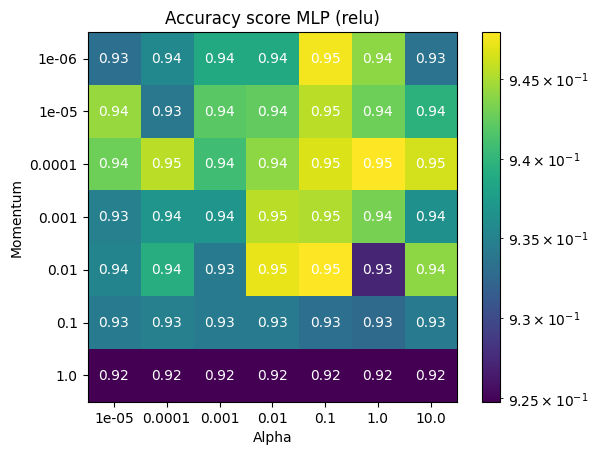

In [50]:
grid_search_hyperparameters_MLP(X_train, X_test, Y_train, Y_test, "Accuracy score MLP (relu)", func="relu", verbose=True)

alpha:1e-05, momentum :1e-06 gives accuracy 0.9412
alpha:1e-05, momentum :1e-05 gives accuracy 0.9448
alpha:1e-05, momentum :0.0001 gives accuracy 0.946
alpha:1e-05, momentum :0.001 gives accuracy 0.9456
alpha:1e-05, momentum :0.01 gives accuracy 0.9428
alpha:1e-05, momentum :0.1 gives accuracy 0.9472
alpha:1e-05, momentum :1.0 gives accuracy 0.9472
alpha:0.0001, momentum :1e-06 gives accuracy 0.946
alpha:0.0001, momentum :1e-05 gives accuracy 0.9444
alpha:0.0001, momentum :0.0001 gives accuracy 0.9444
alpha:0.0001, momentum :0.001 gives accuracy 0.9436
alpha:0.0001, momentum :0.01 gives accuracy 0.9436
alpha:0.0001, momentum :0.1 gives accuracy 0.9444
alpha:0.0001, momentum :1.0 gives accuracy 0.944
alpha:0.001, momentum :1e-06 gives accuracy 0.944
alpha:0.001, momentum :1e-05 gives accuracy 0.946
alpha:0.001, momentum :0.0001 gives accuracy 0.9364
alpha:0.001, momentum :0.001 gives accuracy 0.9424
alpha:0.001, momentum :0.01 gives accuracy 0.946
alpha:0.001, momentum :0.1 gives accur

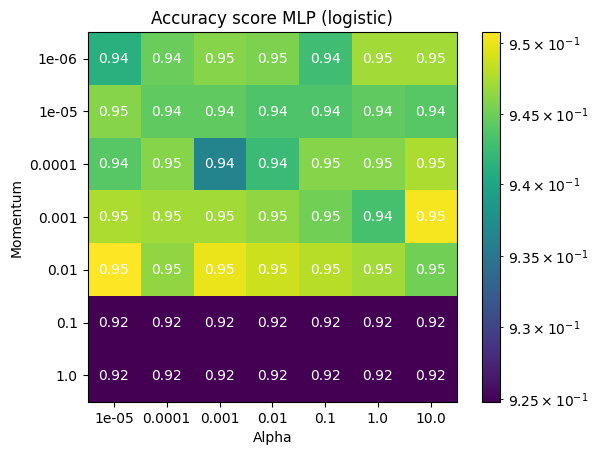

In [51]:
grid_search_hyperparameters_MLP(X_train, X_test, Y_train, Y_test, "Accuracy score MLP (logistic)", func="logistic", verbose=True)


alpha:1e-05, momentum :1e-06 gives accuracy 0.9448
alpha:1e-05, momentum :1e-05 gives accuracy 0.9432
alpha:1e-05, momentum :0.0001 gives accuracy 0.9452
alpha:1e-05, momentum :0.001 gives accuracy 0.9432
alpha:1e-05, momentum :0.01 gives accuracy 0.9456
alpha:1e-05, momentum :0.1 gives accuracy 0.9416
alpha:1e-05, momentum :1.0 gives accuracy 0.944
alpha:0.0001, momentum :1e-06 gives accuracy 0.9448
alpha:0.0001, momentum :1e-05 gives accuracy 0.9504
alpha:0.0001, momentum :0.0001 gives accuracy 0.9372
alpha:0.0001, momentum :0.001 gives accuracy 0.9428
alpha:0.0001, momentum :0.01 gives accuracy 0.9452
alpha:0.0001, momentum :0.1 gives accuracy 0.946
alpha:0.0001, momentum :1.0 gives accuracy 0.942
alpha:0.001, momentum :1e-06 gives accuracy 0.9436
alpha:0.001, momentum :1e-05 gives accuracy 0.94
alpha:0.001, momentum :0.0001 gives accuracy 0.9436
alpha:0.001, momentum :0.001 gives accuracy 0.9368
alpha:0.001, momentum :0.01 gives accuracy 0.9484
alpha:0.001, momentum :0.1 gives accu

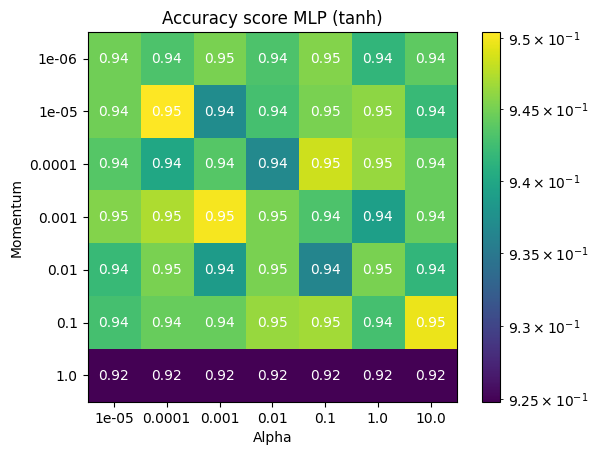

In [52]:
grid_search_hyperparameters_MLP(X_train, X_test, Y_train, Y_test, "Accuracy score MLP (tanh)", func="tahn", verbose=True)


In [55]:
from sklearn.metrics import f1_score

model = MLPClassifier(activation="relu", max_iter=10000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))
print("f1 score:",f1_score(Y_pred, Y_test))

model = MLPClassifier(activation="logistic", max_iter=10000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))
print("f1 score:",f1_score(Y_pred, Y_test))


model = MLPClassifier(activation="tanh", max_iter=10000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_pred, Y_test))
print("f1 score:",f1_score(Y_pred, Y_test))



[[2307  150]
 [   5   38]]
0.938
f1 score: 0.32900432900432897
[[2288  115]
 [  24   73]]
0.9444
f1 score: 0.5122807017543859
[[2267   83]
 [  45  105]]
0.9488
f1 score: 0.621301775147929


Looking at the models f1-score, we see that accuracy is not enough to do a good prediction, we therefore look closer at 
the f1-scores.

alpha:1e-05, momentum :1e-06 gives f1 score 0.563049853372434
alpha:1e-05, momentum :1e-05 gives f1 score 0.6153846153846155
alpha:1e-05, momentum :0.0001 gives f1 score 0.46153846153846156
alpha:1e-05, momentum :0.001 gives f1 score 0.6027397260273972
alpha:1e-05, momentum :0.01 gives f1 score 0.6122448979591837
alpha:1e-05, momentum :0.1 gives f1 score 0.6206896551724137
alpha:1e-05, momentum :1.0 gives f1 score 0.6157894736842104
alpha:0.0001, momentum :1e-06 gives f1 score 0.6223404255319149
alpha:0.0001, momentum :1e-05 gives f1 score 0.46984126984126984
alpha:0.0001, momentum :0.0001 gives f1 score 0.5889570552147239
alpha:0.0001, momentum :0.001 gives f1 score 0.5606936416184971
alpha:0.0001, momentum :0.01 gives f1 score 0.5633802816901409
alpha:0.0001, momentum :0.1 gives f1 score 0.6162464985994398
alpha:0.0001, momentum :1.0 gives f1 score 0.5342019543973942
alpha:0.001, momentum :1e-06 gives f1 score 0.625
alpha:0.001, momentum :1e-05 gives f1 score 0.2889733840304183
alpha

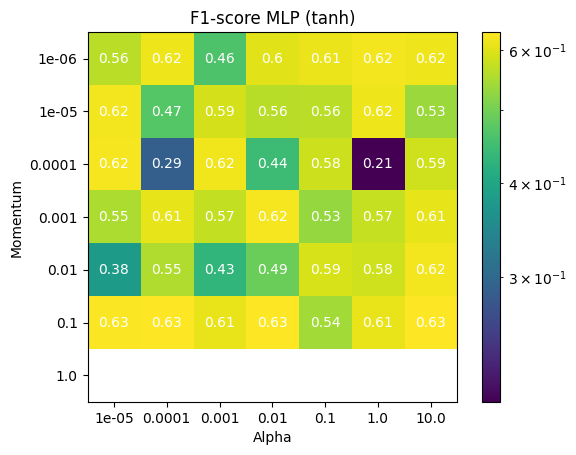

In [4]:
grid_search_hyperparameters_MLP_F1(X_train, X_test, Y_train, Y_test, "F1-score MLP (tanh)", func="tanh", verbose=True)


alpha:1e-05, momentum :1e-06 gives f1 score 0.5568862275449102
alpha:1e-05, momentum :1e-05 gives f1 score 0.5502645502645503
alpha:1e-05, momentum :0.0001 gives f1 score 0.5646437994722956
alpha:1e-05, momentum :0.001 gives f1 score 0.622549019607843
alpha:1e-05, momentum :0.01 gives f1 score 0.6235955056179775
alpha:1e-05, momentum :0.1 gives f1 score 0.46846846846846846
alpha:1e-05, momentum :1.0 gives f1 score 0.5292479108635098
alpha:0.0001, momentum :1e-06 gives f1 score 0.36704119850187267
alpha:0.0001, momentum :1e-05 gives f1 score 0.5811965811965811
alpha:0.0001, momentum :0.0001 gives f1 score 0.3732394366197183
alpha:0.0001, momentum :0.001 gives f1 score 0.6055555555555555
alpha:0.0001, momentum :0.01 gives f1 score 0.34074074074074073
alpha:0.0001, momentum :0.1 gives f1 score 0.5515320334261837
alpha:0.0001, momentum :1.0 gives f1 score 0.40404040404040403
alpha:0.001, momentum :1e-06 gives f1 score 0.5823529411764705
alpha:0.001, momentum :1e-05 gives f1 score 0.4527027

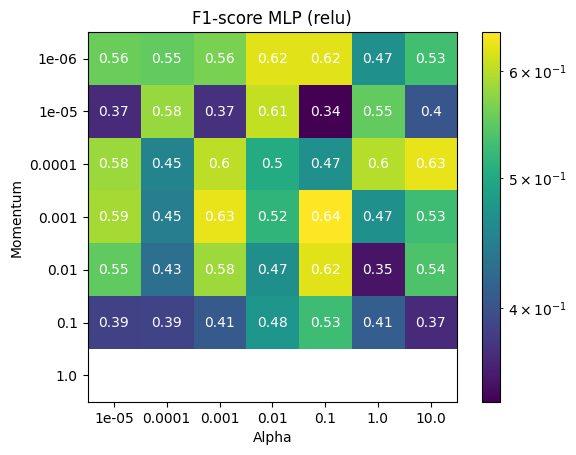

In [5]:
grid_search_hyperparameters_MLP_F1(X_train, X_test, Y_train, Y_test, "F1-score MLP (relu)", func="relu", verbose=True)


alpha:1e-05, momentum :1e-06 gives f1 score 0.5449275362318842
alpha:1e-05, momentum :1e-05 gives f1 score 0.6167146974063402
alpha:1e-05, momentum :0.0001 gives f1 score 0.6041055718475073
alpha:1e-05, momentum :0.001 gives f1 score 0.6324324324324324
alpha:1e-05, momentum :0.01 gives f1 score 0.5959885386819485
alpha:1e-05, momentum :0.1 gives f1 score 0.6332453825857519
alpha:1e-05, momentum :1.0 gives f1 score 0.6397849462365592
alpha:0.0001, momentum :1e-06 gives f1 score 0.5907692307692307
alpha:0.0001, momentum :1e-05 gives f1 score 0.6378378378378379
alpha:0.0001, momentum :0.0001 gives f1 score 0.5276872964169381
alpha:0.0001, momentum :0.001 gives f1 score 0.6301369863013698
alpha:0.0001, momentum :0.01 gives f1 score 0.5964912280701754
alpha:0.0001, momentum :0.1 gives f1 score 0.6312849162011173
alpha:0.0001, momentum :1.0 gives f1 score 0.6744186046511628
alpha:0.001, momentum :1e-06 gives f1 score 0.6358695652173912
alpha:0.001, momentum :1e-05 gives f1 score 0.6336088154

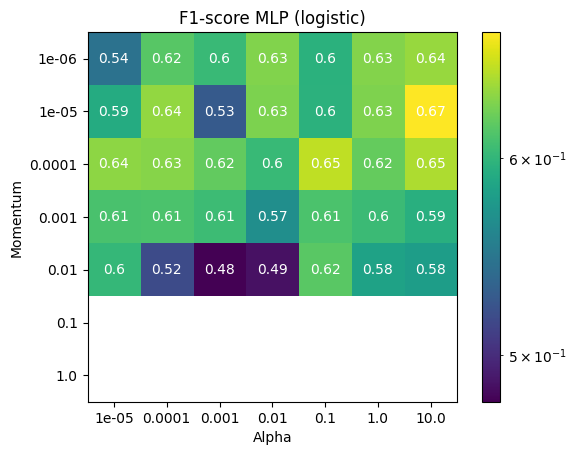

In [6]:
grid_search_hyperparameters_MLP_F1(X_train, X_test, Y_train, Y_test, "F1-score MLP (logistic)", func="logistic", verbose=True)


0
1
2
3
4
5
6


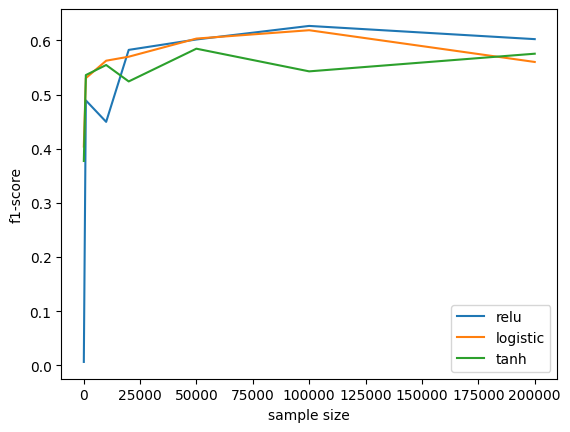

In [11]:
#X, Y = shuffle(X,Y) #Need to shuffle data to make it more random

M_list = [100,1000,10000,20000,50000,100000,200000]
length = len(M_list)
tanh_arr = np.zeros(length)
relu_arr = np.zeros(length)
logistic_arr = np.zeros(length)


for i,M in enumerate(M_list):
    print(i)
    n = len(Y)
    m = int(n/M)
    random_index = np.random.randint(m)*M   
    new_X = X[random_index:random_index+M]
    new_Y = Y[random_index:random_index+M]

    model = MLPClassifier(activation="tanh", max_iter=10000)
    model.fit(new_X, new_Y)
    Y_pred = model.predict(X)
    acc = f1_score(Y_pred, Y)
    tanh_arr[i] = acc

    model = MLPClassifier(activation="logistic", max_iter=10000)
    model.fit(new_X, new_Y)
    Y_pred = model.predict(X)
    acc = f1_score(Y_pred, Y)
    logistic_arr[i] = acc

    model = MLPClassifier(activation="relu", max_iter=10000)
    model.fit(new_X, new_Y)
    Y_pred = model.predict(X)
    acc = f1_score(Y_pred, Y)
    relu_arr[i] = acc

plt.plot(M_list, relu_arr, label="relu")
plt.plot(M_list, logistic_arr, label="logistic")
plt.plot(M_list, tanh_arr, label="tanh")
plt.ylabel("f1-score")
plt.xlabel("sample size")
plt.legend()
plt.savefig("../figures/f1_scores")


Now we do same for forest of trees method

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
#Testing random forest for the whole data set first
forest = RandomForestClassifier(random_state=1)
forest.fit(X, Y)

RandomForestClassifier(random_state=1)

In [19]:
Y_pred = forest.predict(X)
print(accuracy_score(Y, Y_pred))
print(f1_score(Y,Y_pred))
print("predicted chance of dying:",np.sum(Y_pred)/len(Y_pred))
print("Actual chance of dying:",np.sum(Y)/len(Y))


[[963873   7760]
 [ 18310  58632]]
0.9751376868607395
0.8181171250366278
predicted chance of dying: 0.06331640559807358
Actual chance of dying (test set): 0.0808


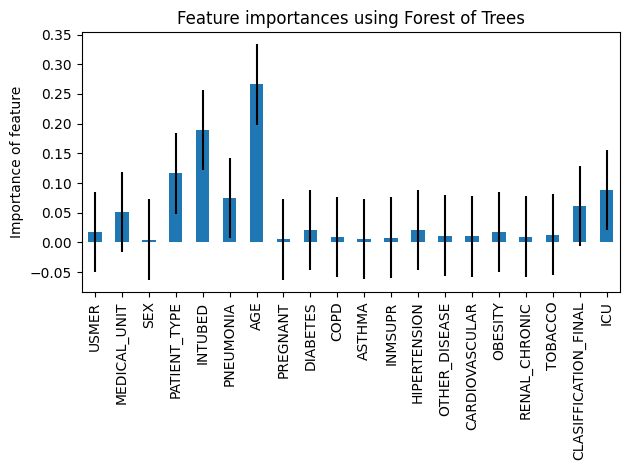

In [21]:
importances = forest.feature_importances_
std = np.std(importances)
forest_importances = pd.Series(importances, index=headers)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Forest of Trees")
ax.set_ylabel("Importance of feature")
fig.tight_layout()
plt.savefig("../figures/Feature_importance.png")

Here we see the most important features are medical_unit, patient_type, intubed, pneumonia, Age, classification_final and icu.

0
1
2
3
4
5
6


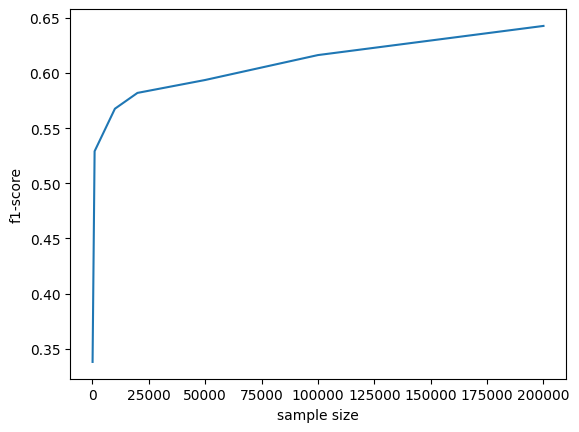

In [23]:
forest_arr = np.zeros(len(M_list))
for i,M in enumerate(M_list):
    print(i)
    n = len(Y)
    m = int(n/M)
    random_index = np.random.randint(m)*M   
    new_X = X[random_index:random_index+M]
    new_Y = Y[random_index:random_index+M]

    forest.fit(new_X, new_Y)
    Y_pred = forest.predict(X)
    acc = f1_score(Y, Y_pred)
    forest_arr[i] = acc

plt.plot(M_list, forest_arr)
plt.xlabel("sample size")
plt.ylabel("f1-score")
plt.savefig("../figures/f1_score_forest")

We now want to study the most important feature, which forest of trees told us was age. 

Text(0.5, 0, 'Age')

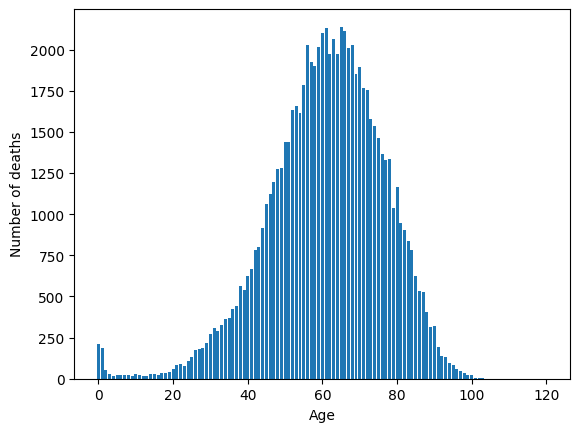

In [33]:
#Making histogram of amount of deaths given a certain age
headers, X, Y = load_covid_data()
X,Y = shuffle(X,Y)

Age = X[:,6]
deaths = {i:0 for i in np.unique(Age)}
for i in range(len(Y)):
    deaths[Age[i]] += Y[i]

plt.bar(range(len(deaths)), list(deaths.values()))
plt.ylabel("Number of deaths")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

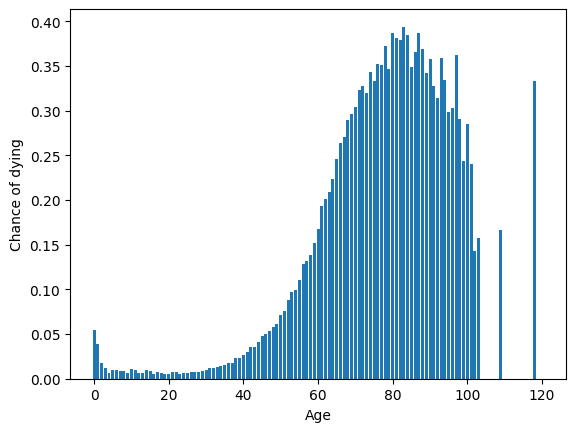

In [34]:
#Making histogram of chance of dying given a certain age
chance_dying = deaths.copy()
amount = {i:0 for i in np.unique(Age)}

for i in range(len(Y)):
    amount[Age[i]] += 1

for key in chance_dying:
    chance_dying[key] /= amount[key]

plt.bar(range(len(chance_dying)), list(chance_dying.values()))
plt.ylabel("Chance of dying")
plt.xlabel("Age")


In [29]:
#looking into chance of dying based on age 
##Note, not finished, need to figure out way to fix imbalanced data

Age_train = X_train[:,6].reshape(-1,1)
Age_test = X_test[:,6].reshape(-1,1)

model = MLPClassifier(activation="logistic", max_iter=10000)
model.fit(Age_train, Y_train)
YA_pred = model.predict(Age_test)
print(accuracy_score(YA_pred, Y_test))
print(f1_score(YA_pred, Y_test))



[[2298  201]
 [   0    1]]
0.9196
0.009852216748768473


In [30]:
forestAge = RandomForestClassifier(random_state=1)
forestAge.fit(Age_train, Y_train)
pred = forestAge.predict(Age_test)
accuracy_score(pred, Y_test)
print(f1_score(pred, Y_test))

[[2294  199]
 [   4    3]]
0.028708133971291863


Seems we arent able to classify based on just age. This makes sence since every percentage based on age is lower than 50, so
our classifier would not benefit from setting any given age as death.
We therefore try with polynomial fitting.

In [32]:
def ChanceDying(X,Y):
    ages = np.unique(X)
    deaths = {i:0 for i in ages}
    numb = deaths.copy()
    for i in range(len(Y)):
        deaths[X[i]] += Y[i]
        numb[X[i]] += 1


    for key in deaths:
        if numb[key] > 0:
            deaths[key] /= numb[key] 
    
    return deaths 

def MakeArray(dict):
    length = len(dict)
    x_arr = np.zeros(length)
    y_arr = np.zeros(length)

    for i,key in enumerate(dict):
        x_arr[i] = key 
        y_arr[i] = dict[key]

    return x_arr, y_arr



In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [39]:

Age = X[:,6]
M = len(Age) #chosen number of data points
n = len(Age)
m = int(n/M)
random_index = np.random.randint(m)*M   
new_Age = Age[random_index:random_index+M]
new_Y = Y[random_index:random_index+M]

Age_train, Age_test, YA_train, YA_test = train_test_split(new_Age, new_Y, test_size=0.2)

deaths_train = ChanceDying(Age_train, YA_train)
probx_train, proby_train = MakeArray(deaths_train)

deaths_test = ChanceDying(Age_test, YA_test)
probx_test, proby_test = MakeArray(deaths_test)

#Testing to find optimal polynomial degree
for i in range(20):
    lin = LinearRegression()
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(probx_train.reshape(-1,1))
    lin.fit(X_poly, proby_train)

    X_poly_test = poly.fit_transform(probx_test.reshape(-1,1))
    print(i, MSE(proby_test, lin.predict(X_poly_test)))


0 0.03446671900115265
1 0.024818953240011602
2 0.025422402951708573
3 0.022131575259928617
4 0.022252909079370997
5 0.019702957810055176
6 0.018822112222042494
7 0.01883442996205261
8 0.018840789663332972
9 0.018900391385648536
10 0.018896709685852265
11 0.01896926899659569
12 0.019076234121270425
13 0.019193359268168963
14 0.019302730958078735
15 0.01940545988800614
16 0.01953923016942262
17 0.01979758494504593
18 0.01966774798456033
19 0.023285176547578744


Doing multiple runs it seems around 10 is the most stable amount of polynomials.

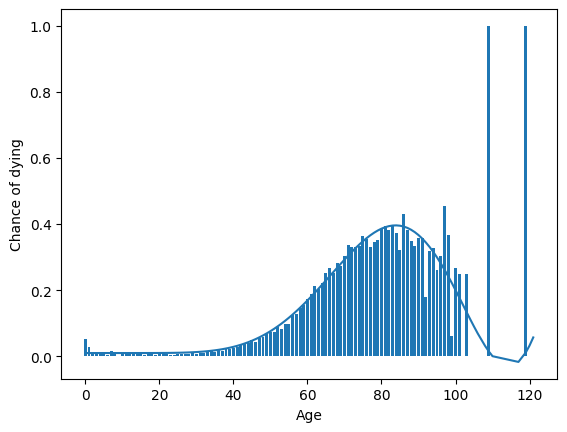

Text(0, 0.5, 'Chance of dying')

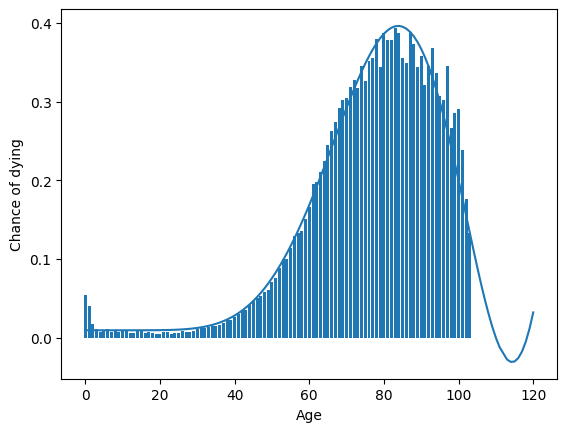

In [40]:
lin = LinearRegression()
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(probx_train.reshape(-1,1))
lin.fit(X_poly, proby_train)

X_poly_test = poly.fit_transform(probx_test.reshape(-1,1))

plt.plot(probx_test, lin.predict(X_poly_test))
plt.bar(probx_test, proby_test)
plt.xlabel("Age")
plt.ylabel("Chance of dying")
plt.show()

plt.bar(probx_train, proby_train)
plt.plot(probx_train, lin.predict(X_poly))
plt.xlabel("Age")
plt.ylabel("Chance of dying")

0.0011215073153509735


<BarContainer object of 121 artists>

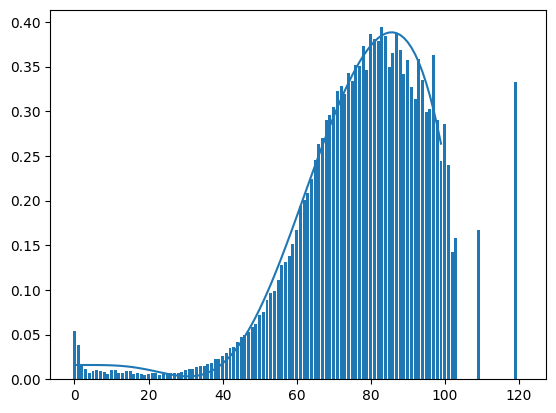

In [44]:
pred = lin.predict(X_poly_test)
length = len(pred)
X_true, ans = MakeArray(chance_dying)
print(MSE(ans[:length], pred))


length = 100
X_poly_true = poly.fit_transform(X_true.reshape(-1,1))
plt.plot(X_true[:length], lin.predict(X_poly_true[:length]))
plt.bar(X_true, ans)

Now testing for different sample sizes 

MSE for sample size 1000 is: 0.022965906698833274
MSE for sample size 10000 is: 13.813351311738055
MSE for sample size 20000 is: 0.003124004595571672
MSE for sample size 50000 is: 0.0003807476793935195
MSE for sample size 100000 is: 0.0006722539694184944
MSE for sample size 200000 is: 0.0013034477275347335
MSE for sample size 500000 is: 0.0008550301106757311


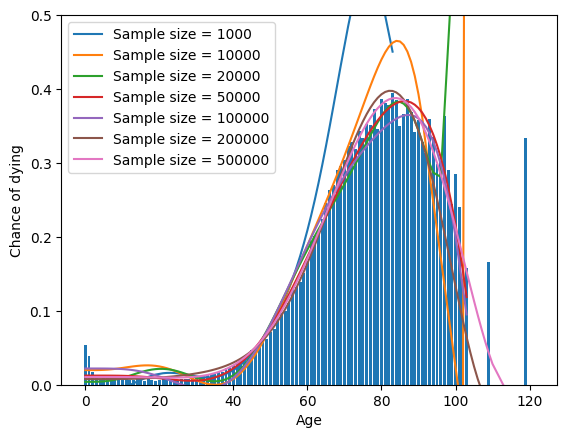

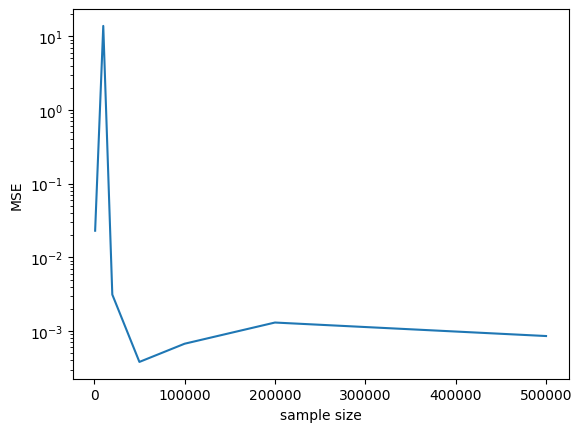

In [54]:

X_true, ans = MakeArray(chance_dying)

M_list1 = [1000,10000,20000,50000,100000,200000,500000]

mse_arr = np.zeros(len(M_list1))
bootstrap_iter = 10

for i,M in enumerate(M_list1):
    Age = X[:,6]
    
    #Shuffling data because it seems not random enough for good resampling
    new_Age, new_Y = shuffle(Age,Y)

    #M = len(Age) #chosen number of data points
    n = len(Age)
    m = int(n/M)
    random_index = np.random.randint(m)*M   
    new_Age = new_Age[random_index:random_index+M]
    new_Y = new_Y[random_index:random_index+M]

    Age_train, Age_test, YA_train, YA_test = train_test_split(new_Age, new_Y, test_size=0.2)

    deaths_train = ChanceDying(Age_train, YA_train)
    probx_train, proby_train = MakeArray(deaths_train)

    deaths_test = ChanceDying(Age_test, YA_test)
    probx_test, proby_test = MakeArray(deaths_test)

    lin = LinearRegression()
    poly = PolynomialFeatures(degree=10)
    X_poly = poly.fit_transform(probx_train.reshape(-1,1))
    lin.fit(X_poly, proby_train)

    X_poly_test = poly.fit_transform(probx_test.reshape(-1,1))
    pred = lin.predict(X_poly_test)
    plt.plot(probx_test, pred, label=f"Sample size = {M}")
    
    mse = MSE(ans[:len(pred)], pred)
    print(f"MSE for sample size {M} is:",mse)
    mse_arr[i] = mse
    #length = 100
    #X_poly_true = poly.fit_transform(X_true.reshape(-1,1))
    #plt.plot(X_true[:length], lin.predict(X_poly_true[:length]))
    

plt.legend()
plt.ylim(0,0.5)
plt.xlabel("Age")
plt.ylabel("Chance of dying")
plt.bar(X_true, ans)
plt.savefig("../figures/chance_of_dying_differentSamples")
plt.show()

plt.plot(M_list1, mse_arr)
plt.ylabel("MSE")
plt.xlabel("sample size")
plt.yscale('log')
plt.savefig("../figures/MSE_Chance_dying")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


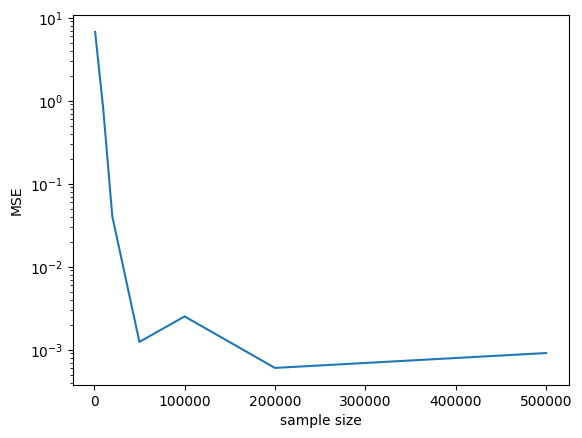

In [53]:
mse_arr = np.zeros(len(M_list1))
bootstrap_iter = 20


for _ in range(bootstrap_iter):
    print(_)
    for i,M in enumerate(M_list1):
        Age = X[:,6]
        
        #Shuffling data because it seems not random enough for good resampling
        new_Age, new_Y = shuffle(Age,Y)

        #M = len(Age) #chosen number of data points
        n = len(Age)
        m = int(n/M)
        random_index = np.random.randint(m)*M   
        new_Age = new_Age[random_index:random_index+M]
        new_Y = new_Y[random_index:random_index+M]

        Age_train, Age_test, YA_train, YA_test = train_test_split(new_Age, new_Y, test_size=0.2)

        deaths_train = ChanceDying(Age_train, YA_train)
        probx_train, proby_train = MakeArray(deaths_train)

        deaths_test = ChanceDying(Age_test, YA_test)
        probx_test, proby_test = MakeArray(deaths_test)

        lin = LinearRegression()
        poly = PolynomialFeatures(degree=10)
        X_poly = poly.fit_transform(probx_train.reshape(-1,1))
        lin.fit(X_poly, proby_train)

        X_poly_test = poly.fit_transform(probx_test.reshape(-1,1))
        pred = lin.predict(X_poly_test)
        
        mse = MSE(ans[:len(pred)], pred)
        mse_arr[i] += mse

mse_arr /= bootstrap_iter
plt.plot(M_list1, mse_arr)
plt.ylabel("MSE")
plt.xlabel("sample size")
plt.yscale('log')
plt.savefig("../figures/MSE_Chance_dying_bootstrap")

Looking at the MSE for sample sizes, it seems about 50 000 samples is enough to justify a good enough MSE.
We can also see this on the lines plot, where the red curve seems well fitted to our actual data.

We now do the same but compare to to the actual input data as a prediction:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


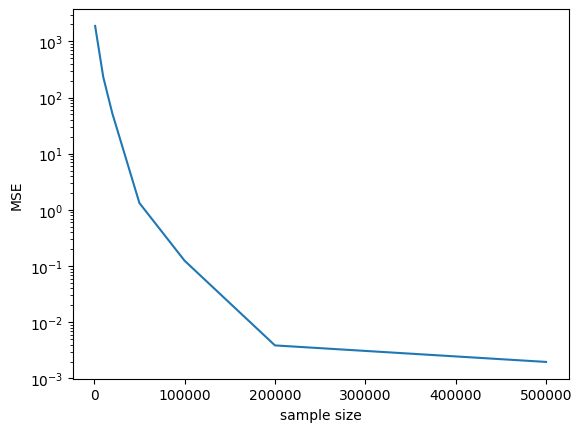

In [55]:
mse_arr = np.zeros(len(M_list1))
bootstrap_iter = 20


for _ in range(bootstrap_iter):
    print(_)
    for i,M in enumerate(M_list1):
        Age = X[:,6]
        
        #Shuffling data because it seems not random enough for good resampling
        new_Age, new_Y = shuffle(Age,Y)

        #M = len(Age) #chosen number of data points
        n = len(Age)
        m = int(n/M)
        random_index = np.random.randint(m)*M   
        new_Age = new_Age[random_index:random_index+M]
        new_Y = new_Y[random_index:random_index+M]


        deaths_train = ChanceDying(new_Age, new_Y)
        probx_train, proby_train = MakeArray(deaths_train)

        deaths_test = ChanceDying(Age, Y)
        probx_test, proby_test = MakeArray(deaths_test)

        lin = LinearRegression()
        poly = PolynomialFeatures(degree=10)
        X_poly = poly.fit_transform(probx_train.reshape(-1,1))
        lin.fit(X_poly, proby_train)

        X_poly_test = poly.fit_transform(probx_test.reshape(-1,1))
        pred = lin.predict(X_poly_test)
        
        mse = MSE(ans, pred)
        mse_arr[i] += mse

mse_arr /= bootstrap_iter
plt.plot(M_list1, mse_arr)
plt.ylabel("MSE")
plt.xlabel("sample size")
plt.yscale('log')
plt.savefig("../figures/MSE_Chance_dying_bootstrap_FULLDATA")

We see when comparing to actual data as a test, we need about 100-200 000 samples to make a good enough estimate where we can 
be content with our prediction.

We now want to look at our models again to try to make them better by removing some unnecesarry features.
they were  medical_unit, patient_type, intubed, pneumonia, Age, classification_final and icu

In [85]:
index_kept = [1,3,4,5,6,18,19]
for i in index_kept:
    print(headers[i])

X_new_features = X.copy()
for i in range(len(headers)-1, -1, -1):
    if i not in index_kept:
        X_new_features = np.delete(X_new_features, i, 1)


for i,idx in enumerate(index_kept):
    np.testing.assert_array_equal(X_new_features[:,i], X[:,idx])

MEDICAL_UNIT
PATIENT_TYPE
INTUBED
PNEUMONIA
AGE
CLASIFFICATION_FINAL
ICU


With our new features we test again on the whole data set, for forest of trees first

In [86]:
#Testing random forest for the whole data set first
forest = RandomForestClassifier(random_state=1)
forest.fit(X_new_features, Y)

Y_pred = forest.predict(X_new_features)
print(accuracy_score(Y, Y_pred))
print(f1_score(Y,Y_pred))
print("predicted chance of dying:",np.sum(Y_pred)/len(Y_pred))
print("Actual chance of dying:",np.sum(Y)/len(Y))


[[958770  12863]
 [ 35320  41622]]
0.9540490665903727
0.6333858339610583
predicted chance of dying: 0.05196099468326062
Actual chance of dying: 0.07337767923133777


In [ ]:
model = MLPClassifier(activation="relu", max_iter=10000)
model.fit(X_new_features, Y)
Y_pred = model.predict(X_new_features)
print(accuracy_score(Y_pred, Y))
print("f1 score:",f1_score(Y_pred, Y))

model = MLPClassifier(activation="tanh", max_iter=10000)
model.fit(X_new_features, Y)
Y_pred = model.predict(X_new_features)
print(accuracy_score(Y_pred, Y))
print("f1 score:",f1_score(Y_pred, Y))

model = MLPClassifier(activation="logistic", max_iter=10000)
model.fit(X_new_features, Y)
Y_pred = model.predict(X_new_features)
print(accuracy_score(Y_pred, Y))
print("f1 score:",f1_score(Y_pred, Y))

